## Simulation generator for XClone

In [108]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport xclone_config
project_config = xclone_config
os.chdir(project_config.ROOT)

from collections import Counter, defaultdict, OrderedDict
import itertools
from itertools import product as cartesian
import multiprocessing as mp
import pickle

import numba
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import toolkit
import util
from workspace.workspace_manager import WorkspaceManager

sns.set()

workspace = {}
for modality in ["scDNA", "scRNA"]:
    workspace.update({ 
        modality : WorkspaceManager(
            task_name="classification",
            experiment_info={
                "sample" : "STP_G&T",
                "modality" : modality
            },
            verbose=True
        )
    })
    workspace[modality].load_workspace()
    
assert workspace["scDNA"].experiment_info["sample"]\
        == workspace["scRNA"].experiment_info["sample"],\
    "scDNA and scRNA workspaces store different samples"

sample_tag = workspace["scDNA"].experiment_info["sample"]
print(f"Currently working on {sample_tag}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Currently working on STP_G&T


### Loading G&T data

In [224]:
from scipy.sparse import load_npz

D_DNA = load_npz(workspace["scDNA"].dir + "/block_DP.npz").todense()
D_RNA = load_npz(workspace["scRNA"].dir + "/block_DP.npz").todense()

CNV_DNA = util.pickle_load(workspace["scDNA"].dir + "/CNV_DNA.pkl")
I_DNA = util.pickle_load(workspace["scDNA"].dir + "/I_DNA.pkl")
tau = util.pickle_load(workspace["scDNA"].dir + "/tau.pkl")
T = util.pickle_load(workspace["scDNA"].dir + "/T.pkl")

print(f"RAW, ({I_DNA.size} cells)")
display(pd.DataFrame(
    np.column_stack((
        np.arange(CNV_DNA.shape[1]), 
        np.round(100 * np.mean(np.isnan(CNV_DNA), axis=0))
    )), columns=["cluster", "% of NaNs"]
))

cells_to_keep = (I_DNA != 6)
clusters_to_keep = [0, 1, 2, 3, 4, 5, 7, 8]
D_DNA = D_DNA[:, cells_to_keep]
D_RNA = D_RNA[:, cells_to_keep]
I_DNA = I_DNA[cells_to_keep]
I_DNA[I_DNA > 6] = I_DNA[I_DNA > 6] - 1
CNV_DNA = CNV_DNA[:, clusters_to_keep]
T = T[:, clusters_to_keep]

print(f"W/O cluster 6 of dead cells ({I_DNA.size} cells remain)")
display(pd.DataFrame(
    np.column_stack((
        np.arange(CNV_DNA.shape[1]), 
        np.round(100 * np.mean(np.isnan(CNV_DNA), axis=0))
    )), columns=["cluster", "% of NaNs"]
))

print(f"RAW: ({D_DNA.shape[0]} blocks in each cell)")

idx = np.all(T > 0, axis=1) * np.all(~np.isnan(T), axis=1)

T = T[idx, :]
D_RNA = np.nan_to_num(D_RNA[idx, :])
D_DNA = np.nan_to_num(D_DNA[idx, :])

print(f"ONLY NON-MISSING: ({D_DNA.shape[0]} blocks in each cell)")

RAW, (89 cells)


,cluster,% of NaNs
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,6.0
4,4.0,0.0
5,5.0,0.0
6,6.0,53.0
7,7.0,0.0
8,8.0,0.0


W/O cluster 6 of dead cells (80 cells remain)


,cluster,% of NaNs
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,6.0
4,4.0,0.0
5,5.0,0.0
6,6.0,0.0
7,7.0,0.0


RAW: (10152 blocks in each cell)
ONLY NON-MISSING: (5912 blocks in each cell)


/icgc/dkfzlsdf/analysis/B260/users/v390v/.conda/envs/xclone/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


In [227]:
%%time
from classification.xclone_model.xclone_distrib import XCloneDistrib
from classification.xclone_model.xclone_gibbs_sampler import XCloneGibbsSampler
from classification.xclone_model.xclone_engine import XCloneEngine

simulation_kwargs = {
    "tau" : tau,
    "T_mat" : T,
    "D_DNA_seed" : D_DNA,
    "D_RNA_seed" : D_RNA,
    "n_cell" : 50,
    "random_seed" : 179
}

simulated_datadict = xclone_routines.simulate_G_T(**simulation_kwargs)
simulated_params = XCloneDistrib.from_dict(simulated_datadict)

sampler = XCloneGibbsSampler()

xclone = XCloneEngine(
    workspace_dict=workspace,
    params=simulated_params,
    sampler=sampler,
    report_dir="/icgc/dkfzlsdf/analysis/B260/users/v390v/"\
                "xclone/data/tmp/xclone/STP_G&T/"\
                "05_11_2019/evening_run/simulated_data",
    verbose=True
)
xclone

CPU times: user 3.43 s, sys: 411 ms, total: 3.84 s
Wall time: 2.79 s


XCloneEngine, 2019-2020, Stegle Lab
Report dir: /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/xclone/STP_G&T/05_11_2019/evening_run/simulated_data
This instance was created on 06/11/2019 01:25:48
DNA sample: STP_G&T
Cells in DNA sample: 50
RNA sample: STP_G&T
Cells in RNA sample: 50
Total number of CNV-haploblocks: 5912
Number of clones: 8
0 fitting iterations already passed
Sampler used: <class 'classification.xclone_model.xclone_gibbs_sampler.XCloneGibbsSampler'>
Initial total loglikelihood: -632799.2047352244
Current best total loglikelihood: -632710.8508334017

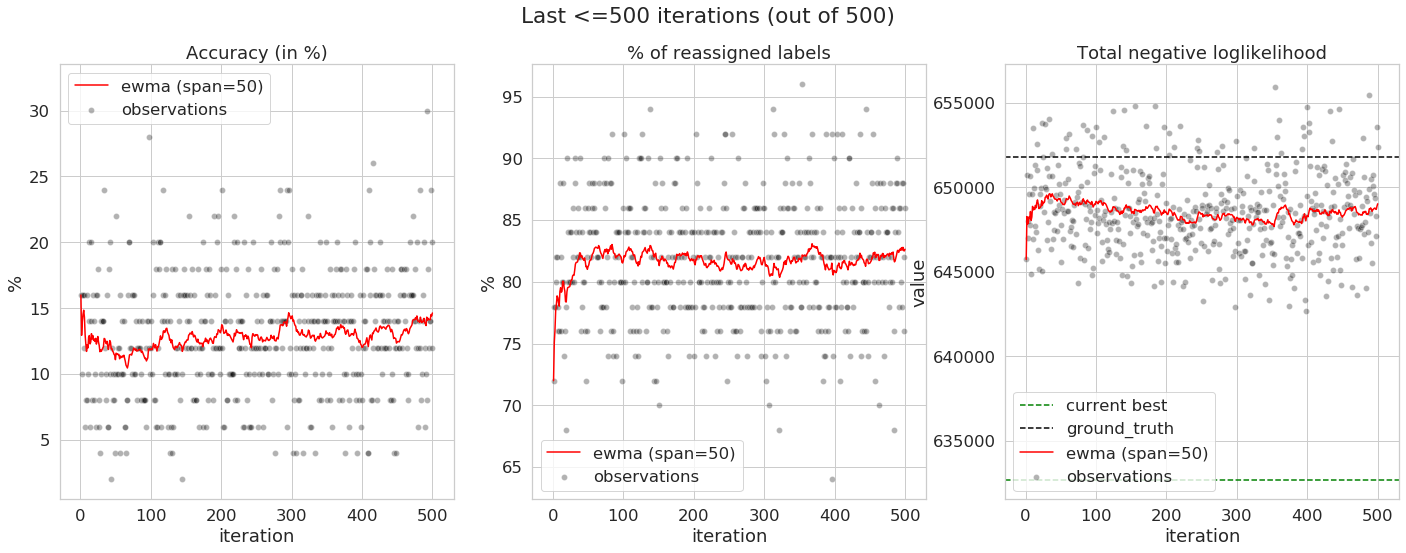

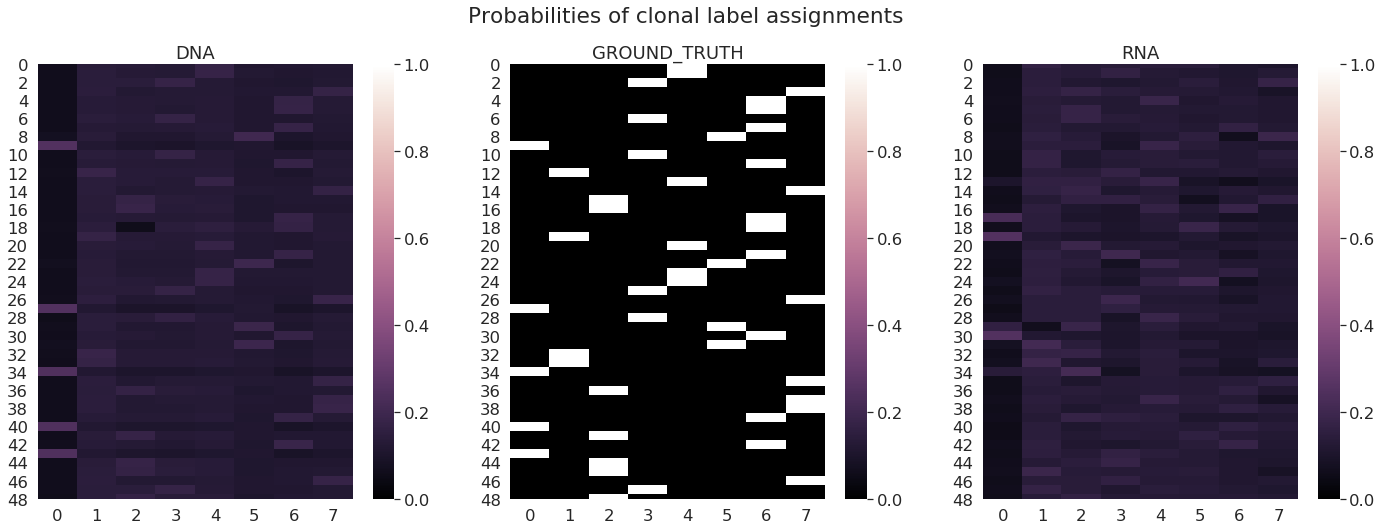

[-576094.79320193  -56616.05763147]


In [ ]:
%%time
%matplotlib inline

from classification.xclone_model.xclone_diagnostics import gt_callback, GTConvergenceTracker
sns.set(font_scale=1.5, style="whitegrid")

xclone.fit(10000, gt_callback, GTConvergenceTracker())